# Outdoor spaces, culture, student satisfaction and research excellence at UK universities

## Alistair Knock
#### Full report: https://github.com/alistairknock/Coursera_Capstone/blob/master/Outdoors%20spaces%20-%20draft%20report.md
#### Summary presentation: https://github.com/alistairknock/Coursera_Capstone/blob/master/Outdoor%20spaces%20-%20summary%20presentation.pdf
#### Jupyter notebook: this file

## Section 1: Introduction/Business Problem

Prospective students to universities in the UK are now able to access a wealth of quantitative information about the courses and universities they could study at. While teaching and research reputation are clearly important contributors to the decision of staff and students to join a given university, they do not fully describe the experience of spending several years in one physical location. The metrics are output-oriented – for instance, student satisfaction at the very end of the course, the employability of graduates, the end-product outputs and impacts of academic research, and so on. 

Most students will attend a handful of university open days once they’ve formed a shortlist, a list which will often be academically determined based on course content and predicted grades – but could we help provide ‘soft’ information on the 160 UK universities through the combination of geodata, student satisfaction and research excellence data, so that these shortlists can be informed by a broader set of criteria? Do satisfied students tend to be concentrated in certain types of environment? Is world-class research related to the facilities and locale of the university?

## Section 2: Data


The business problem identifies several datasources to explore:

* student satisfaction
* research excellence
* geographic data describing the area around each university

These datasets can be obtained publicly and via registered access to geodata systems as follows:

* student satisfaction data is published by the UK's Office for Students through the [National Student Survey](https://www.officeforstudents.org.uk/advice-and-guidance/student-information-and-data/national-student-survey-nss/get-the-nss-data/)
* research excellence data is captured through the Research Excellence Framework exercise administered by sector agencies, with the [most recent data available from REF 2014](https://www.ref.ac.uk/2014/results/intro/)
* basic geographic data on UK universities including latitude and longitude is available from the [UK Learning Providers website](http://learning-provider.data.ac.uk/)
* detailed geographic data on facilities and services in the vicinity of each universities is available through the [Foursquare API](https://developer.foursquare.com/docs/api/venues/search)

In [1]:
# API credentials to remove prior to sharing

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'

We begin by obtaining copies of the three relevant flat files with the aim of removing unneeded columns and to restructure them into one dataframe which contains one record per university, the latitude/longitude, the student satisfaction measure, and research excellence measures.

In [2]:
# List of universities and latitude/longitude
#!wget -q -O 'universities.csv' http://learning-provider.data.ac.uk/data/learning-providers-plus.csv

# National Student Survey (NSS) results for teaching providers in 2018
#!wget -q -O 'nss.xlsx' https://www.officeforstudents.org.uk/nss2018/NSS_taught_all18.xlsx

# Research Excellence Framework (REF) results from 2014
#!wget -q -O 'ref.xlsx' https://results.ref.ac.uk/\(S\(tfvnmup54ktqh01rztz5tg3m\)\)/DownloadFile/AllResults/xlsx

Store university data in the main dataframe

In [3]:
import pandas as pd, numpy as np

uni_df = pd.read_csv('universities.csv')
uni_df.drop(columns=['ALIAS','FLAT_NAME_NUMBER','BUILDING_NAME_NUMBER','LOCALITY','STREET_NAME','TOWN','POSTCODE','WEBSITE_URL','WIKIPEDIA_URL','GROUPS','EASTING','NORTHING','GTR_ID'],inplace=True)
uni_df['UKPRN'] = uni_df['UKPRN'].astype(str)
uni_df.set_index('UKPRN',inplace=True)

Store National Student Survey (NSS) data in a second dataframe, then merge the final satisfaction question (Q27) into the university data

In [4]:
nss_df = pd.read_excel('nss.xlsx', sheet_name=1,skiprows=3)
# The NSS data provides the proportion of respondents who answer each question using a Likert scale (definitely disagree... definitely agree), and also pre-calculates the percentage who agree and definitely agree.  
# We are only interested in this last percentage, so drop the individual answers and the confidence intervals
nss_df.drop(columns=['Confidence interval - min','Confidence interval - max','Answered 1','Answered 2','Answered 3','Answered 4','Answered 5','N/A','Two years aggregate data?'],inplace=True)
nss_df.head()

,UKPRN,Provider,Question Number,Actual value,Response,Sample Size
0,10007783,University of Aberdeen,Q01,0.91,1397,2043
1,10007783,University of Aberdeen,Q02,0.84,1395,2043
2,10007783,University of Aberdeen,Q03,0.88,1396,2043
3,10007783,University of Aberdeen,Q04,0.79,1395,2043
4,10007783,University of Aberdeen,Q05,0.86,1395,2043


In [5]:
# The set of question labels can be found at: https://officeforstudents.org.uk/media/0445deaa-b0fa-4cfb-8867-e5db228fa02e/nss-full-questionnaire-2018-ipsos.pdf
# Isolate the final question, question 27 'Overall, I am satisfied with the quality of the course'
q27_df = nss_df.loc[nss_df['Question Number'] == 'Q27',['UKPRN','Actual value']]
q27_df.rename(columns={"Actual value": "NSS_Q27"},inplace=True)
q27_df['UKPRN'] = q27_df['UKPRN'].astype(str)
q27_df.set_index('UKPRN',inplace=True)
# Add the NSS result to the university list - note this is a left merge so only selects NSS results for the smaller number of universities in the university dataframe, other results are discarded.  This is consistent with the business problem/data discussion where we are only interested in full-service institutions
#q27_df
uni_merge_df = uni_df.merge(q27_df,how='left',on='UKPRN')
uni_merge_df.head()

,PROVIDER_NAME,VIEW_NAME,SORT_NAME,LONGITUDE,LATITUDE,HESA_ID,NSS_Q27
UKPRN,,,,,,,
10008640,FALMOUTH UNIVERSITY,University College Falmouth,"Falmouth, University College",-5.070901,50.149168,17.0,0.80
10007774,UNIVERSITY OF OXFORD,University of Oxford,"Oxford, University of",-1.262868,51.757644,156.0,NaN
10007768,UNIVERSITY OF LANCASTER,University of Lancaster,"Lancaster, University of",-2.786905,54.010480,123.0,0.88
10000571,BATH SPA UNIVERSITY,Bath Spa University,Bath Spa University,-2.437400,51.378739,48.0,0.81
10007814,CARDIFF UNIVERSITY,Cardiff University,Cardiff University,-3.179907,51.489093,179.0,0.83


Store research excellence (REF) data in a third dataframe.

In [6]:
ref_df = pd.read_excel('ref.xlsx',skiprows=7,na_values=['-','ZZZZZZZZ'])
ref_df.rename(index=str,columns={"Institution code (UKPRN)": "UKPRN", "Institution name": "PROVIDER_NAME","FTE Category A staff submitted": "STAFF_FTE"}, inplace=True)
ref_df.drop(columns=['Institution sort order','Main panel','Unit of assessment number','Unit of assessment name','Multiple submission letter','Multiple submission name','Joint submission'],inplace=True)
#ref_df.index
ref_df.dropna(inplace=True)
ref_df['UKPRN'] = ref_df['UKPRN'].astype(int).astype(str)
ref_df.head()

,UKPRN,PROVIDER_NAME,Profile,STAFF_FTE,4*,3*,2*,1*,unclassified
0,10000291,Anglia Ruskin University,Outputs,11.3,6.4,68.1,25.5,0.0,0.0
1,10000291,Anglia Ruskin University,Impact,11.3,20.0,80.0,0.0,0.0,0.0
2,10000291,Anglia Ruskin University,Environment,11.3,12.5,75.0,12.5,0.0,0.0
3,10000291,Anglia Ruskin University,Overall,11.3,10.0,72.0,18.0,0.0,0.0
4,10000291,Anglia Ruskin University,Outputs,13.7,10.3,61.5,25.6,2.6,0.0


REF data is captured per university and per unit of assessment (subject) - we are looking for a university average, so we must recalculate this average using the individual unit scores and the weighting dimension (staff full-time equivalent (FTE) gives a relative weighting between units).  

REF data also exists for four profiles - Outputs, Impact, Environment and then an Overall score.  We transform the data for each of these four profiles.

The REF assessment categorises each university's submission into 4 quality bands (plus unclassified), where 4* is the best and 1* is the lowest band. The final step performs a check to ensure the weighting process still results in the quality bands totalling 100%.

In [7]:
staff_totals_df = ref_df.loc[ref_df['Profile'] == 'Overall'].groupby(['UKPRN']).sum()
staff_totals_df.rename(index=str,columns={"STAFF_FTE": "STAFF_FTE_TOTAL"},inplace=True)
staff_totals_df.drop(columns=['4*','3*','2*','1*','unclassified'],inplace=True)

ref_merge_df = ref_df.merge(staff_totals_df,on='UKPRN')

# Calculate a weighted average for each of the measures
ref_merge_df['s4*'] = ref_merge_df['4*'] * (ref_merge_df['STAFF_FTE'] / ref_merge_df['STAFF_FTE_TOTAL'])
ref_merge_df['s3*'] = ref_merge_df['3*'] * (ref_merge_df['STAFF_FTE'] / ref_merge_df['STAFF_FTE_TOTAL'])
ref_merge_df['s2*'] = ref_merge_df['2*'] * (ref_merge_df['STAFF_FTE'] / ref_merge_df['STAFF_FTE_TOTAL'])
ref_merge_df['s1*'] = ref_merge_df['1*'] * (ref_merge_df['STAFF_FTE'] / ref_merge_df['STAFF_FTE_TOTAL'])
ref_merge_df['sunclassified'] = ref_merge_df['unclassified'] * (ref_merge_df['STAFF_FTE'] / ref_merge_df['STAFF_FTE_TOTAL'])
ref_merge_df.drop(columns=['STAFF_FTE','4*','3*','2*','1*','unclassified','STAFF_FTE_TOTAL'],inplace=True)

# check that the weighted averaging leaves intact percentages across the 4*-unclassified divisions, 
# If the output of this section is empty, then the averaging process has worked and the quality bands
# do always add back up to 100%
ref_totals_df = ref_merge_df.groupby(['UKPRN','Profile'],as_index=False).sum()
ref_totals_df['check'] = ref_totals_df['s4*'] +  ref_totals_df['s3*'] +  ref_totals_df['s2*'] + ref_totals_df['s1*'] +  ref_totals_df['sunclassified']
ref_totals_df.loc[(ref_totals_df['check'] > 100.01) & (ref_totals_df['check'] < 99.99)]


,UKPRN,Profile,s4*,s3*,s2*,s1*,sunclassified,check


There are different methods of aggregating up from the 4 quality bands, including a grade point average.  In this report we have decided to focus on the proportion of submissions which attract the top quality bands (4 and 3 star submissions) as a way of differentiating between research excellence at universities, so we create a new column to hold this subtotal, and then pivot the dataset so that there is one row per university and a 3+4 star score for each of the profiles.  This is the same structure as the main university dataset so we can then merge it to create our single version of the three static data files.

In [8]:
ref_totals_df['3and4*'] = ref_totals_df['s4*'] + ref_totals_df['s3*']
ref_totals_df.drop(columns=['s4*','s3*','s2*','s1*','sunclassified','check'],inplace=True)
ref_34star_pivot_df = ref_totals_df.pivot_table(values='3and4*', index=['UKPRN'], columns=['Profile']).reset_index()
ref_34star_pivot_df.head()

Profile,UKPRN,Environment,Impact,Outputs,Overall
0,10000291,26.664588,46.579116,48.607870,44.848123
1,10000385,10.000000,40.000000,51.900000,43.000000
2,10000571,36.448257,63.794447,54.045785,53.109160
3,10000824,61.260816,71.740544,55.927256,59.863412
4,10000886,77.833477,91.578344,57.486723,67.329228


In [9]:
univs_df = uni_merge_df.merge(ref_34star_pivot_df,how='left',on='UKPRN')
univs_df.set_index("UKPRN")
univs_df.head()

,UKPRN,PROVIDER_NAME,VIEW_NAME,SORT_NAME,LONGITUDE,LATITUDE,HESA_ID,NSS_Q27,Environment,Impact,Outputs,Overall
0,10008640,FALMOUTH UNIVERSITY,University College Falmouth,"Falmouth, University College",-5.070901,50.149168,17.0,0.80,19.281603,30.718397,29.154455,28.143679
1,10007774,UNIVERSITY OF OXFORD,University of Oxford,"Oxford, University of",-1.262868,51.757644,156.0,NaN,99.084577,91.576979,83.011394,87.190315
2,10007768,UNIVERSITY OF LANCASTER,University of Lancaster,"Lancaster, University of",-2.786905,54.010480,123.0,0.88,97.534495,92.786958,75.680012,82.283201
3,10000571,BATH SPA UNIVERSITY,Bath Spa University,Bath Spa University,-2.437400,51.378739,48.0,0.81,36.448257,63.794447,54.045785,53.109160
4,10007814,CARDIFF UNIVERSITY,Cardiff University,Cardiff University,-3.179907,51.489093,179.0,0.83,94.755083,96.197132,83.097026,87.406886


### Integrity check

We now get set up for Foursquare querying; first of all we plot our universities on the map to ensure our data is intact.

In [10]:
!conda install -c conda-forge geocoder --yes 
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [11]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json

import requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [12]:
centre_latitude = 53.8083752
centre_longitude = -1.5542572

centres_map = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=6) 
for lat, lng, label in zip(univs_df.LATITUDE, univs_df.LONGITUDE, univs_df.UKPRN):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(centres_map)

centres_map

### Foursquare API

Foursquare data will be obtained giving the count and types of facilities (‘venues’ in Foursquare language) within a five kilometre radius of the university, using the _search_ endpoint.  This radius was selected since it is the average human hourly walking speed and is felt to be a reasonable maximum distance that staff and students would travel to access a facility. Clearly longer distances can be travelled using public transport or car, but the assumption is that facilities which are within walking or cycling distance will be used regularly, and it is regular use which contributes to the ‘what it is like to be there’ aspects of this investigation.

The getMatchingVenues function takes lat/long and a single category (it would also take a list of comma-separated categories but here we have chosen to iterate through each category individually, since early tests showed that many results of a multi-category search would exceed the 50 result Foursquare limit and so be limited in their usefulness.  By querying each category individually we increase the number of calls to the Foursquare API but increase the possible number of results substantially and lower the risk of hitting the 50 result limit).

The writecsv argument can be provided to write a static CSV copy of the results to avoid hitting the API unnecessarily.  These CSVs can be deleted should a refresh of the data be required.

In [13]:
LIMIT = 50

geolocator = Nominatim(user_agent="foursquare_agent")

def getMatchingVenues(names, latitudes, longitudes, category, writecsv, radius=5000):
    
    venues_list=[]
    i = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        err = ""
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
        
        #print(url)
                
        # make the GET request
        try:
            #print(requests.get(url).json())
            results = requests.get(url).json()["response"]["venues"]
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['location']['distance'],  
                v['categories'][0]['name']) for v in results])
        except Exception as e:
            print("Error: {} / {} / {}".format(e, requests.get(url).json(), requests.get(url).headers)) #err = 'Error encountered getting {}, will store partial results if obtained'.format(cat)

    #if err != "":
#        print(err)
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    print(nearby_venues.shape)
    nearby_venues.columns = ['UKPRN', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance',
                  'Venue Category']    

    if writecsv:
        pd.DataFrame([item for venue_list in venues_list for item in venue_list]).to_csv('catoutputs/{}.csv'.format(category))
       
    
    return(nearby_venues)

A list of relevant categories was manually obtained from the [Foursquare categories endpoint](https://developer.foursquare.com/docs/api/venues/categories)

The local CSV is read for each category if it exists, otherwise calls to the Foursquare API are made and the CSV can be written if requested.

The shape of the dataframe is reported in each case to check for any deformed or empty result sets.

In [14]:
unisearch_df = univs_df # this was for testing purposes, to avoid disturbing the master dataframe  .loc[:10]

category_list = [# Arts & Entertainment
'56aa371be4b08b9a8d5734db',	# Amphitheater
'4fceea171983d5d06c3e9823',	# Aquarium
'4bf58dd8d48988d1e2931735', # Art Gallery
'4bf58dd8d48988d18e941735',	# Comedy Club
'5032792091d4c4b30a586d5c',	# Concert Hall
'56aa371be4b08b9a8d573532',	# Exhibit
'4deefb944765f83613cdba6e',	# Historic Site
'5642206c498e4bfca532186c',	# Memorial Site
'4bf58dd8d48988d17f941735',	# Movie Theater
'4bf58dd8d48988d181941735',	# Museum
'4bf58dd8d48988d1e5931735',	# Music Venue
'4bf58dd8d48988d1f2931735',	# Performing Arts Venue
'507c8c4091d498d9fc8c67a9',	# Public Art
'4bf58dd8d48988d184941735',	# Stadium
'4bf58dd8d48988d17b941735',	# Zoo
# Event
'5267e4d9e4b0ec79466e48c6',	# Conference
'5267e4d9e4b0ec79466e48c9',	# Convention
'5267e4d9e4b0ec79466e48c7',	# Festival
'5267e4d9e4b0ec79466e48d1',	# Music Festival
'5bae9231bedf3950379f89c5',	# Sporting Event
#'5267e4d8e4b0ec79466e48c5',	# Street Fair - no results
'5bae9231bedf3950379f89c3',	# Trade Fair
# Outdoors & Recreation
'4f4528bc4b90abdf24c9de85',	# Athletics & Sports
'52e81612bcbc57f1066b7a28',	# Bathing Area
'4bf58dd8d48988d1e2941735',	# Beach
'56aa371be4b08b9a8d57355e',	# Bike Trail
#'52e81612bcbc57f1066b7a22',	# Botanical Garden - no results
'4bf58dd8d48988d1e4941735',	# Campground
'56aa371be4b08b9a8d573562',	# Canal
'50aaa49e4b90af0d42d5de11', # Castle
'52e81612bcbc57f1066b7a23', 	# Forest
'4bf58dd8d48988d1e0941735', 	# Harbor / Marina
'4bf58dd8d48988d161941735', 	# Lake
'4eb1d4d54b900d56c88a45fc', 	# Mountain - no results
'52e81612bcbc57f1066b7a21', 	# National Park - no results
'52e81612bcbc57f1066b7a13', 	# Nature Preserve - no results
#'4bf58dd8d48988d162941735', 	# Other Great Outdoors
'4bf58dd8d48988d163941735', 	# Park
'52e81612bcbc57f1066b7a25', 	# Pedestrian Plaza
'4bf58dd8d48988d1e7941735',   # Playground
'4bf58dd8d48988d164941735', 	# Plaza
'4bf58dd8d48988d15e941735', 	# Pool
'52e81612bcbc57f1066b7a29', 	# Rafting
'52e81612bcbc57f1066b7a26', 	# Recreation Centre
'4eb1d4dd4b900d56c88a45fd', 	# River
'50328a4b91d4c4b30a586d6b', 	# Rock Climbing Spot
'4bf58dd8d48988d165941735', 	# Scenic Lookout
'4bf58dd8d48988d166941735', 	# Sculpture Garden
'4bf58dd8d48988d1e9941735', 	# Ski Area
'58daa1558bbb0b01f18ec1b9', 	# Skydiving Drop Zone
'5bae9231bedf3950379f89d0', 	# State/Provincial Park
'52e81612bcbc57f1066b7a10', 	# Summer Camp
'4bf58dd8d48988d159941735', 	# Trail
'56aa371be4b08b9a8d573560', 	# Waterfall
# Professional & Other Places
'4bf58dd8d48988d173941735', 	# Auditorium
'56aa371be4b08b9a8d5734cf', 	# Ballroom
'52e81612bcbc57f1066b7a34', 	# Community Center
'52e81612bcbc57f1066b7a32', 	# Cultural Center
'4bf58dd8d48988d12f941735', 	# Library
'5744ccdfe4b0c0459246b4d9', 	# Observatory
'52e81612bcbc57f1066b7a33', 	# Social Club
'4bf58dd8d48988d131941735' 	# Spiritual Center  
]

uni_results = {}
i = 0

for cat in category_list:
    i = i + 1
    loaded = False
    try:
        uni_results[cat] = pd.read_csv("catoutputs/{}.csv".format(cat))
        print("Locally loaded {}/{}: {} | {}".format(i, len(category_list), cat, uni_results[cat].shape))
        
        uni_results[cat].drop(columns=["Unnamed: 0"],inplace=True)
        uni_results[cat].columns = ['UKPRN', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance',
                  'Venue Category']            
        
        loaded = True
    except Exception as e:
        print(e)
    
    if not loaded:
        print("Retrieving {}/{}: {}".format(i, len(category_list), cat))
        uni_results[cat] = getMatchingVenues(names=unisearch_df['UKPRN'], latitudes=unisearch_df['LATITUDE'],longitudes=unisearch_df['LONGITUDE'],category=cat,writecsv=True) #,categories=",".join(category_list))


Locally loaded 1/59: 56aa371be4b08b9a8d5734db | (58, 9)
Locally loaded 2/59: 4fceea171983d5d06c3e9823 | (104, 9)
Locally loaded 3/59: 4bf58dd8d48988d1e2931735 | (4270, 9)
Locally loaded 4/59: 4bf58dd8d48988d18e941735 | (1461, 9)
Locally loaded 5/59: 5032792091d4c4b30a586d5c | (1440, 9)
Locally loaded 6/59: 56aa371be4b08b9a8d573532 | (1032, 9)
Locally loaded 7/59: 4deefb944765f83613cdba6e | (2698, 9)
Locally loaded 8/59: 5642206c498e4bfca532186c | (844, 9)
Locally loaded 9/59: 4bf58dd8d48988d17f941735 | (2498, 9)
Locally loaded 10/59: 4bf58dd8d48988d181941735 | (2797, 9)
Locally loaded 11/59: 4bf58dd8d48988d1e5931735 | (4409, 9)
Locally loaded 12/59: 4bf58dd8d48988d1f2931735 | (4534, 9)
Locally loaded 13/59: 507c8c4091d498d9fc8c67a9 | (2214, 9)
Locally loaded 14/59: 4bf58dd8d48988d184941735 | (1944, 9)
Locally loaded 15/59: 4bf58dd8d48988d17b941735 | (1012, 9)
Locally loaded 16/59: 5267e4d9e4b0ec79466e48c6 | (68, 9)
Locally loaded 17/59: 5267e4d9e4b0ec79466e48c9 | (12, 9)
Locally loaded

In [15]:
uni_venues = pd.DataFrame()

for x in uni_results.values():
    uni_venues = uni_venues.append(x)

uni_venues.columns = ['UKPRN', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance',
                  'Venue Category']    

uni_venues.head()

,UKPRN,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,10007779,51.536862,-0.133498,Rish Mix,51.523882,-0.068887,4701,Amphitheater
1,10007779,51.536862,-0.133498,Garden Marquee,51.526064,-0.135270,1208,Amphitheater
2,10007162,51.517742,-0.117099,Rish Mix,51.523882,-0.068887,3408,Amphitheater
3,10007162,51.517742,-0.117099,Garden Marquee,51.526064,-0.135270,1562,Amphitheater
4,10007761,51.510734,-0.116912,Rish Mix,51.523882,-0.068887,3634,Amphitheater


We onehot encode the dataset to transform existence of a venue in each category to true/false (1/0) and then sum the total counts in each category for each university.

In [16]:
# one hot encoding
uni_onehot = pd.get_dummies(uni_venues[['Venue Category']], prefix="", prefix_sep="")

# add identifier column back to dataframe
uni_onehot['UKPRN'] = uni_venues['UKPRN'].astype(str)
fixed_columns = [uni_onehot.columns[-1]] + list(uni_onehot.columns[:-1])
uni_onehot = uni_onehot[fixed_columns]

uni_group = uni_onehot.groupby('UKPRN').sum().reset_index()

uni_group.drop(columns='Zoo Exhibit',inplace=True) # this was added through the Zoo category but is a subset of venues within that main venue
uni_group.set_index('UKPRN',inplace=True)

uni_group.head()

,Acupuncturist,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,...,Volleyball Court,Water Park,Waterfall,Waterfront,Weight Loss Center,Well,Whisky Bar,Windmill,Yoga Studio,Zoo
UKPRN,,,,,,,,,,,,,,,,,,,,,
10000291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10000385,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,4,1
10000571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000712,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
10000824,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,4,1


## Methodology / Analysis


Now to perform some initial visualisation on the results to better understand the distribution of the dataset.  

Firstly some statistics on the dataset:


In [245]:
count_positive_facilities = uni_group.sum(axis=1).sum(axis=0)
count_universities = len(uni_group)
count_categories = 59
print('Total number of universities:', count_universities) # note that we are currently obtaining data for ALL universities in the master list, not just those with NSS and REF data.  So this count and the graphs below will be higher than the resulting output
print('Total number of positive facilities:', count_positive_facilities)
print('Average positive facilities per universities: {:.2f}'.format(count_positive_facilities /count_universities))
print('Average positive facilities per category: {:.2f}'.format(count_positive_facilities / count_categories))

Total number of universities: 166
Total number of positive facilities: 80948
Average positive facilities per universities: 487.64
Average positive facilities per category: 1372.00


Then using a bar chart to see whether some categories are represented more highly than others across the dataset:

Text(0.5, 1.0, 'Total count of positive facilities across all universities, split by category (where count is greater than 100)')

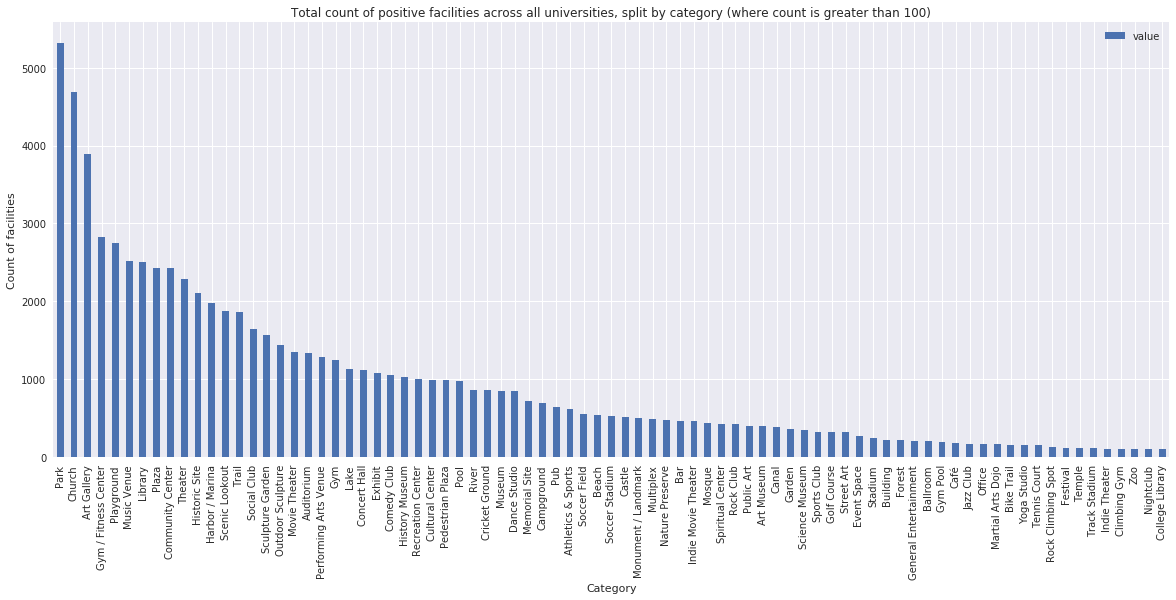

In [18]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn') 
#print(plt.style.available)


#chk = uni_group.drop(columns=["TotalCount"]).melt(id_vars='UKPRN')
chk = uni_group.reset_index().melt(id_vars='UKPRN')
chk = chk.drop(columns='UKPRN').groupby(['variable']).sum()
chk = chk.loc[chk['value'] > 100].sort_values(by=['value'],ascending=False)


ax = chk.plot(kind='bar', figsize=(20, 8))

ax.set_xlabel('Category') # add to x-label to the plot
ax.set_ylabel('Count of facilities') # add y-label to the plot
ax.set_title('Total count of positive facilities across all universities, split by category (where count is greater than 100)') # add title to the plot

# plt.show()

Of the 81,0000 positive facilities found, parks and churches constitute over 10%.

Secondly, we look at variability using a boxplot showing the spread of universities  within each category.

Text(0.5, 1.0, 'Box plot distribution of universities and their count of positive facilities each category (top 20 categories only)')

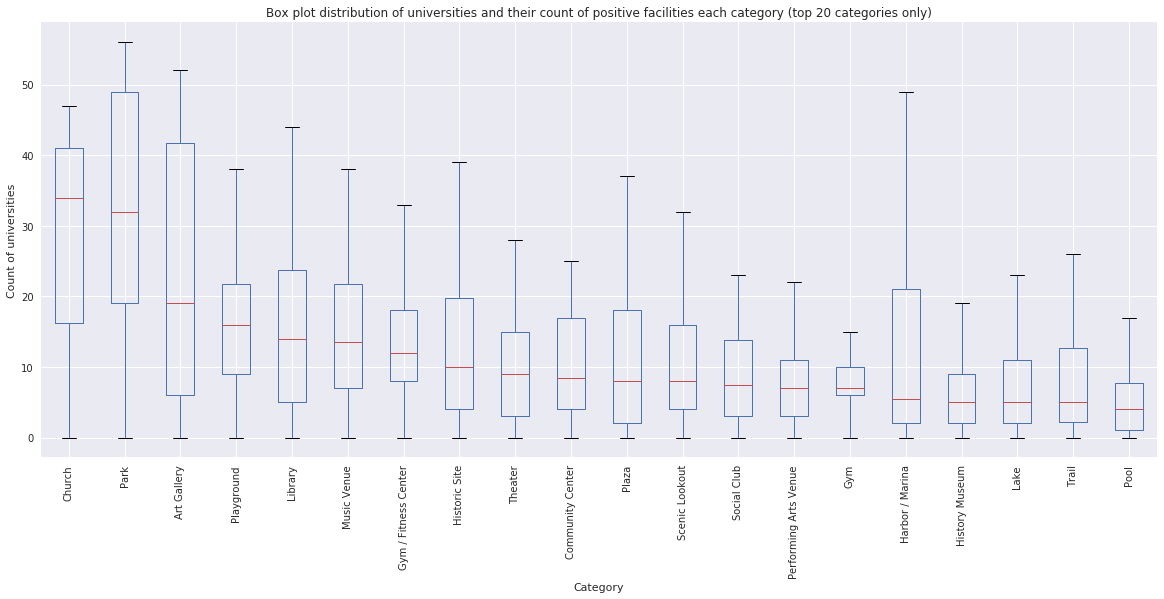

In [19]:
chk = uni_group

chk = chk.reindex(chk.median().sort_values(ascending=False).index, axis=1).iloc[:,0:20]

ax = chk.plot(kind='box', figsize=(20, 8), rot=90)

ax.set_xlabel('Category') # add to x-label to the plot
ax.set_ylabel('Count of universities') # add y-label to the plot
#ax.set_rot(90)
ax.set_title('Box plot distribution of universities and their count of positive facilities each category (top 20 categories only)') # add title to the plot

Some of these plots give a clue to the geography - for instance, harbor/marina has a comparatively low median value, but high upper quartile and outlier markers, because where some harbor facilities exist there are likely to be many more around it due to proximity to the coastline.  The same pattern can be observed with Art Gallery (cities) and Trail (countryside).

Finally, using a histogram to observe the number of universities which have X numbers of venues around them to identify whether the distribution is relatively normal.  At this point a total count of all venues in all categories is added (i.e. the total number of venues within 5 kilometres of the university which are of the 'positive' type of category listed).  This gives a way of comparing the relative environment of each university.

Text(0.5, 1.0, 'Histogram showing counts of universities with X positive facilities')

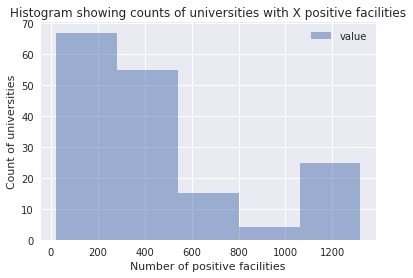

In [20]:
chk = uni_group.reset_index().melt(id_vars='UKPRN')
chk = chk[chk.variable != 'TotalCount']
chk = chk.groupby(['UKPRN']).sum()#

ax = chk.plot.hist(bins=5, alpha=0.5)

ax.set_xlabel('Number of positive facilities') # add to x-label to the plot
ax.set_ylabel('Count of universities') # add y-label to the plot
ax.set_title('Histogram showing counts of universities with X positive facilities') # add title to the plot



This last bar seemed unusual, with a suspicion that it was related to London.  So we map the results again with count as the colour (black as the highest count)

In [21]:
centre_latitude = 51.5287718
centre_longitude = -0.2416796

chk = uni_group.reset_index().melt(id_vars='UKPRN')
chk = chk[chk.variable != 'TotalCount']
chk = chk.groupby(['UKPRN']).sum()

chk.rename(columns={"value": "TotalCount"},inplace=True)

uni_group_geo = chk.merge(univs_df[['UKPRN','LONGITUDE','LATITUDE']].set_index('UKPRN'),how='left',on='UKPRN')

uni_group_geo.dropna(inplace=True)
uni_group_geo.reset_index(inplace=True)


uni_group_geo['COUNTGROUP'] = pd.cut(uni_group_geo['TotalCount'], bins=5, labels=['blue', 'green','yellow','red','black'])


centres_map = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=9) 
for lat, lng, label, countgroup in zip(uni_group_geo.LATITUDE, uni_group_geo.LONGITUDE, str(uni_group_geo.TotalCount), uni_group_geo.COUNTGROUP):
    folium.features.CircleMarker(
        [lat, lng],
        radius=7,
        color= False,
        popup=label,
        fill = True,
        fill_color=countgroup,
        fill_opacity=0.8
    ).add_to(centres_map)
    
centres_map

#uni_merge_df = uni_df.merge(q27_df,how='left',on='UKPRN')

We merge the positive facility total count back into our master data frame.  Null values are set to zero, though there is a question as to whether this is an optimal way to treat these values (non-participation is not the same as a zero mark).

In [22]:
uni_group2 = uni_group.reset_index()
uni_group2['TotalCount'] = uni_group2.sum(axis=1)

univsfull_df = univs_df.merge(uni_group2[['UKPRN','TotalCount']],how='left',on='UKPRN')
univsfull_df
univsfull_df.fillna(0,inplace=True)
null_columns = univsfull_df.columns[univsfull_df.isnull().any()]
univsfull_df.head()

,UKPRN,PROVIDER_NAME,VIEW_NAME,SORT_NAME,LONGITUDE,LATITUDE,HESA_ID,NSS_Q27,Environment,Impact,Outputs,Overall,TotalCount
0,10008640,FALMOUTH UNIVERSITY,University College Falmouth,"Falmouth, University College",-5.070901,50.149168,17.0,0.80,19.281603,30.718397,29.154455,28.143679,156
1,10007774,UNIVERSITY OF OXFORD,University of Oxford,"Oxford, University of",-1.262868,51.757644,156.0,0.00,99.084577,91.576979,83.011394,87.190315,419
2,10007768,UNIVERSITY OF LANCASTER,University of Lancaster,"Lancaster, University of",-2.786905,54.010480,123.0,0.88,97.534495,92.786958,75.680012,82.283201,141
3,10000571,BATH SPA UNIVERSITY,Bath Spa University,Bath Spa University,-2.437400,51.378739,48.0,0.81,36.448257,63.794447,54.045785,53.109160,111
4,10007814,CARDIFF UNIVERSITY,Cardiff University,Cardiff University,-3.179907,51.489093,179.0,0.83,94.755083,96.197132,83.097026,87.406886,496


Now we begin to explore the relationship between the main features (NSS satisfaction, research excellence for the outputs category, and the count of positive facilities near the university).  We note at this point the potential in further research for using many more features from the NSS and REF datasets, and to grouping the FourSquare categories into macro-categories.  The number of features we have selected for this analysis is relatively low, at 3.

To get a view on the relationship between the three features, we visualise NSS Q27 vs research outputs as a scatter:

NSS Q27 vs REF outputs (ignoring zero NSS/REF values)


/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


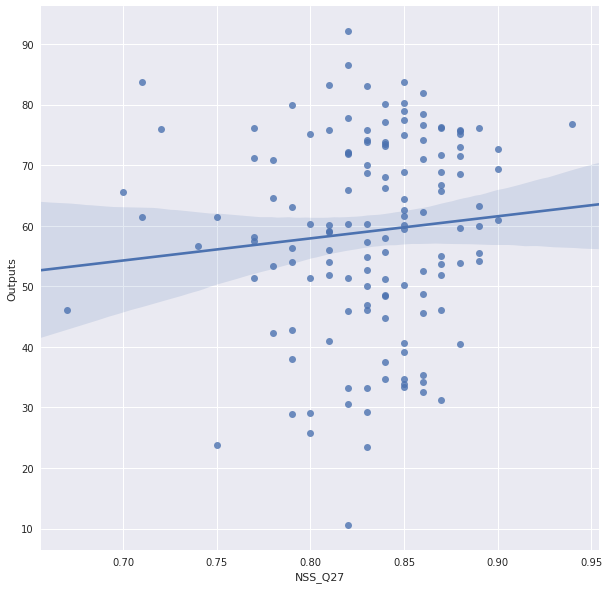

In [23]:
print("NSS Q27 vs REF outputs (ignoring zero NSS/REF values)")
d = univsfull_df.loc[(univsfull_df['NSS_Q27'] != 0) & (univsfull_df['Outputs'] != 0)]
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x='NSS_Q27',y='Outputs',data=d, ax=ax)

Visualise NSS Q27 vs positive facilities as a scatter:

NSS Q27 vs positive facility count (ignoring zero NSS response)


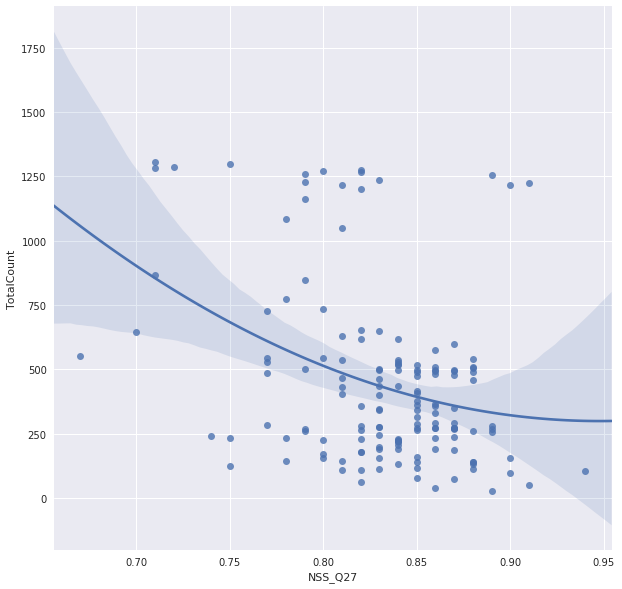

In [24]:
print("NSS Q27 vs positive facility count (ignoring zero NSS response)")
d = univsfull_df.loc[univsfull_df['NSS_Q27'] != 0]
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x='NSS_Q27',y='TotalCount',data=d, order=2,ax=ax)

Visualise research outputs vs positive facilities as a scatter:


REF % 3+4* outputs vs positive facility count  (ignoring zero REF score)


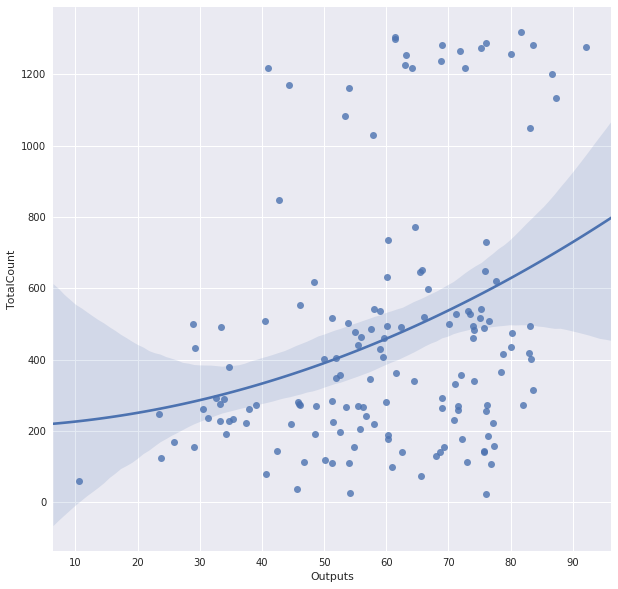

In [25]:
print("REF % 3+4* outputs vs positive facility count  (ignoring zero REF score)")
d = univsfull_df.loc[univsfull_df['Outputs'] != 0]
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x='Outputs',y='TotalCount',data=d, order=2, ax=ax)

The initial scatters indicate there may be a weak negative relationship between student satisfaction - access to greater numbers of facilities correlates to a small decrease in satisfaction.  Conversely, the quality of REF outputs is positively correlated with the number of facilities.

The approach taken to further investigate this is to using k-means clustering and DBSCAN to cluster the data and observe the differences in features between these clusters.  Mapping these clusters will also help to identify any confounding and contributing geographical factors not currently present in the featureset.

### Iteration 1, simple features

First, we scale the features and use the elbow method to identify an appropriate number of clusters (k) and then run k-means clustering on the dataset.

In [67]:
min_max_scaler = preprocessing.MinMaxScaler()

univsclust_df = univsfull_df.drop(columns=['PROVIDER_NAME','VIEW_NAME','SORT_NAME','LONGITUDE','LATITUDE','HESA_ID'])
univsclust_df = univsclust_df.drop(columns=['Impact','Environment','Overall'])
univsclust_scaled = min_max_scaler.fit_transform(univsclust_df)
univdf_normalized = pd.DataFrame(univsclust_scaled, columns=univsclust_df.columns)

univdf_normalized.drop(columns=['UKPRN'],inplace=True)
univdf_normalized['UKPRN'] = univsclust_df['UKPRN'] 

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


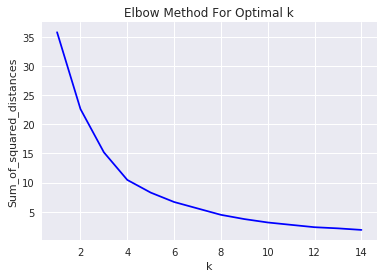

In [68]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(univdf_normalized.drop('UKPRN', 1))
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [69]:
# set number of clusters
kclusters = 4

univ_grouped_clustering = univdf_normalized.drop('UKPRN', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(univ_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
univdf_normalized.insert(0, 'Cluster Labels', kmeans.labels_)

univdf_normalized.drop(columns=['NSS_Q27','Outputs'],inplace=True)
univ_merged = univs_df.join(univdf_normalized.set_index('UKPRN'), on='UKPRN')
univ_merged.drop(columns=['Environment','Overall','Impact'],inplace=True)
univ_merged.rename(columns={"Cluster Labels": "CLUSTER"},inplace=True)

Running a test using DBScan required high epsilon values (0.5 with a normalised range of 0-1.0) and low minimum sample values (10 from 166) to begin to separate any cluster from the noise, which likely indicates that the dataset does not cluster well (either in general or using this density method).

In [156]:
sklearn.utils.check_random_state(1000)
Clus_dataSet = univ_merged[['NSS_Q27','Outputs','TotalCount']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
univ_merged['CLUSTER_DBSCAN'] = labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Count of universities in each cluster:')
univ_merged[['CLUSTER_DBSCAN','UKPRN']].groupby('CLUSTER_DBSCAN').count()

Estimated number of clusters: 1
Estimated number of noise points: 46
Count of universities in each cluster:


,UKPRN
CLUSTER_DBSCAN,
-1,46
0,120


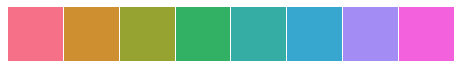

In [70]:
sns.palplot(sns.color_palette("husl", 8))

from scipy import stats


NSS Q27 and Outputs:
Pearson's correlation coefficient: 0.096 (p-value: 0.259)
R-squared: 0.009 (p-value: 0.259)


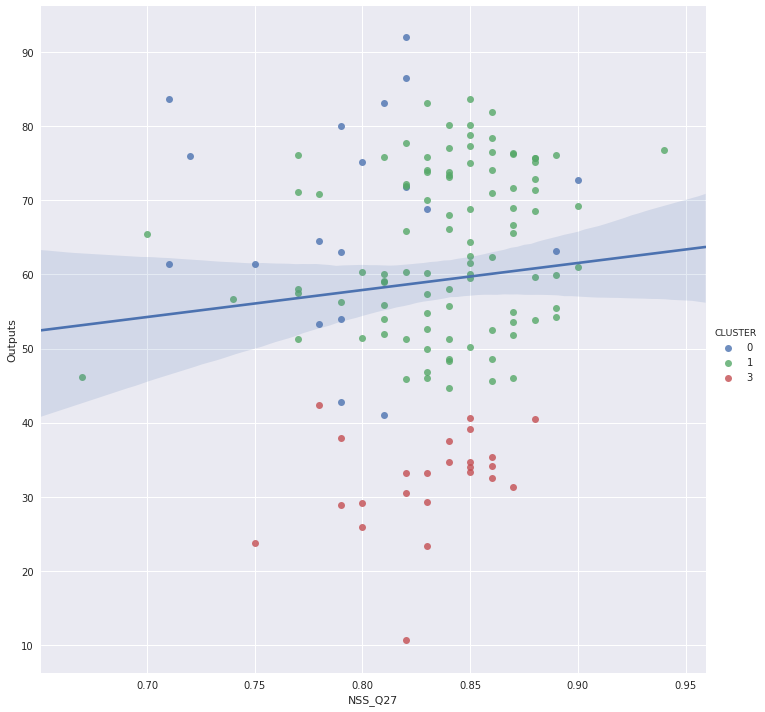

In [113]:
d = univ_merged.loc[univ_merged['NSS_Q27'] != 0].dropna() # not satisfied with dropping the null values here, would really prefer a refactor of this dataset to be clearer on what is in/out
graph = sns.lmplot(x='NSS_Q27',y='Outputs',data=d, hue='CLUSTER', fit_reg=False, height=10)
sns.regplot(x='NSS_Q27',y='Outputs',data=d, scatter=False, ax=graph.axes[0,0])

cor = stats.pearsonr(d['NSS_Q27'],d['Outputs']) 
slope, intercept, r_value, p_value, std_err = stats.linregress(d['NSS_Q27'],d['Outputs'])

print("NSS Q27 and Outputs:")
print("Pearson's correlation coefficient: {:.3f} (p-value: {:.3f})".format(cor[0], cor[1]))
print("R-squared: {:.3f} (p-value: {:.3f})".format(r_value**2, p_value))


Notably cluster 2 does not appear since it has zero NSS values and so is excluded from the graph.

Cluster 3 appears distinct from the other two clusters, and cluster 0 has a very wide range, with points overlapping much of cluster 1.

The regression line is weak and the spread of the clusters does not initially support close correlation.

NSS Q27 and positive facility count:
Pearson's correlation coefficient: -0.390 (p-value: 0.000)
R-squared: 0.152 (p-value: 0.000)


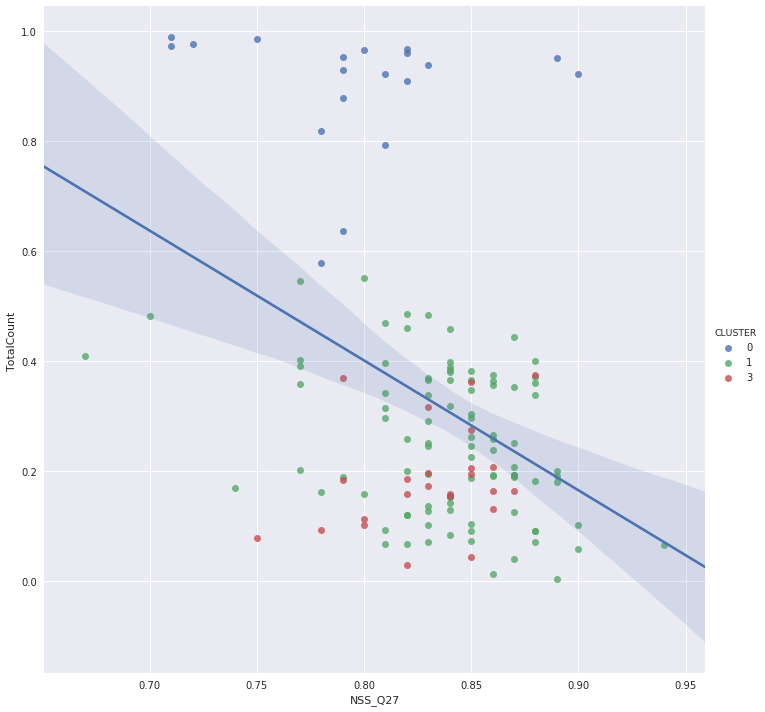

In [115]:
d = univ_merged.loc[univ_merged['NSS_Q27'] != 0].dropna()
#stats.pearsonr(d['NSS_Q27'],d['TotalCount'])
graph = sns.lmplot(x='NSS_Q27',y='TotalCount',data=d, hue='CLUSTER', fit_reg=False, height=10)
sns.regplot(x='NSS_Q27',y='TotalCount',data=d, scatter=False, ax=graph.axes[0,0])

cor = stats.pearsonr(d['NSS_Q27'],d['TotalCount']) # not satisfied with dropping the null values here, would really prefer a refactor of this dataset to be clearer on what is in/out
slope, intercept, r_value, p_value, std_err = stats.linregress(d['NSS_Q27'],d['TotalCount'])

print("NSS Q27 and positive facility count:")
print("Pearson's correlation coefficient: {:.3f} (p-value: {:.3f})".format(cor[0], cor[1]))
print("R-squared: {:.3f} (p-value: {:.3f})".format(r_value**2, p_value))

In contrast to the NSS/REF plot, here cluster 0 is distinct from other clusters, with all points showing high values for the positive facilities feature.  As before, the zero NSS values mean cluster 2 is not plotted.  Cluster 1 and 3 overlap considerably and are not discrete in this view.  The regression line shows a reasonably strong negative correlation, though this may be influenced by the atypically high values from cluster 0.

NSS Q27 and Outputs:
Pearson's correlation coefficient: 0.327 (p-value: 0.000)
R-squared: 0.107 (p-value: 0.000)


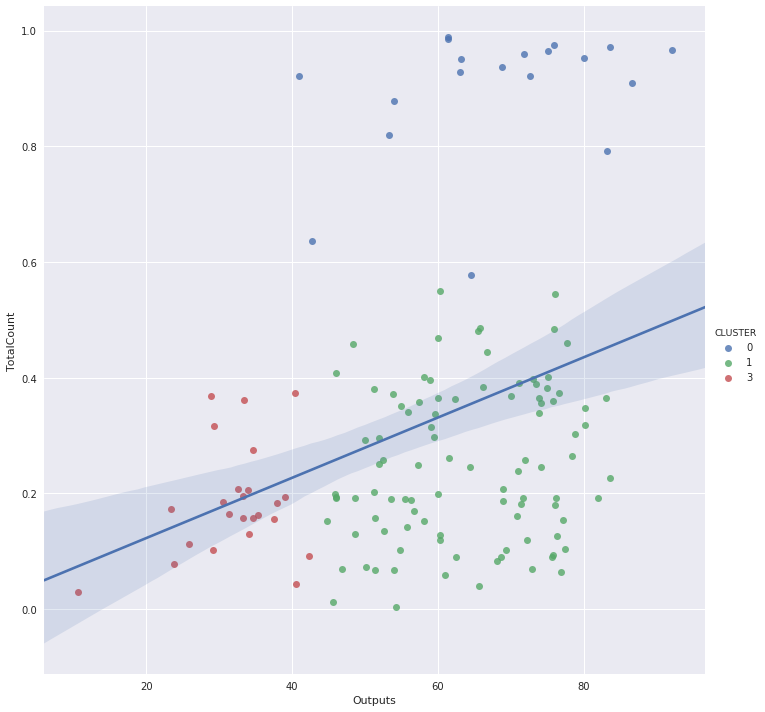

In [111]:
d = univ_merged.loc[univ_merged['Outputs'] != 0].dropna()  # not satisfied with dropping the null values here, would really prefer a refactor of this dataset to be clearer on what is in/out

graph = sns.lmplot(x='Outputs',y='TotalCount',data=d, hue='CLUSTER', fit_reg=False, height=10)
sns.regplot(x='Outputs',y='TotalCount',data=d, scatter=False, ax=graph.axes[0,0])

cor = stats.pearsonr(d['Outputs'],d['TotalCount'])
slope, intercept, r_value, p_value, std_err = stats.linregress(d['Outputs'],d['TotalCount'])

print("Outputs and positive facility count:")
print("Pearson's correlation coefficient: {:.3f} (p-value: {:.3f})".format(cor[0], cor[1]))
print("R-squared: {:.3f} (p-value: {:.3f})".format(r_value**2, p_value))


This chart shows REF outputs against count of positive facilities.  With the exception of cluster 2, here we have clear separation of the clusters, with cluster 0 remaining in the top positive facility range, and the other clusters being separated cleanly by low and mid-high REF performance.  The regression line shows positive correlation.

Now we observe the composition of each cluster using box plots and descriptive statistics to give each cluster a roughly representative label.

/home/jupyterlab/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Text(0.5, 1.0, 'Box plot distribution of universities by cluster, for NSS Q27')

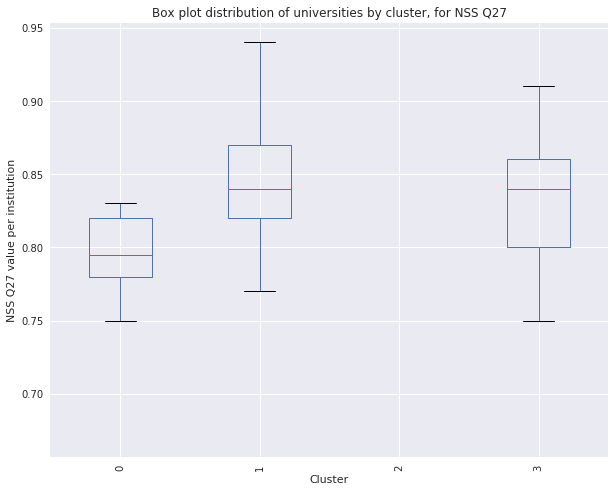

In [74]:
d = univ_merged[['UKPRN','CLUSTER','NSS_Q27','Outputs','TotalCount']]

ax = d.pivot(index='UKPRN',columns='CLUSTER',values='NSS_Q27').plot(kind='box', figsize=(10, 8), rot=90)

ax.set_xlabel('Cluster')
ax.set_ylabel('NSS Q27 value per institution')
ax.set_title('Box plot distribution of universities by cluster, for NSS Q27') 

Text(0.5, 1.0, 'Box plot distribution of universities by cluster, for REF outputs')

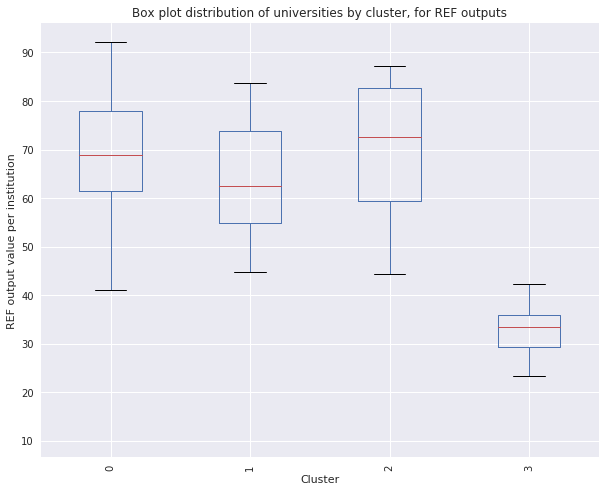

In [75]:
d = univ_merged[['UKPRN','CLUSTER','NSS_Q27','Outputs','TotalCount']]

ax = d.pivot(index='UKPRN',columns='CLUSTER',values='Outputs').plot(kind='box', figsize=(10, 8), rot=90)

ax.set_xlabel('Cluster')
ax.set_ylabel('REF output value per institution')
ax.set_title('Box plot distribution of universities by cluster, for REF outputs') 

Text(0.5, 1.0, 'Box plot distribution of universities by cluster, for positive facility count')

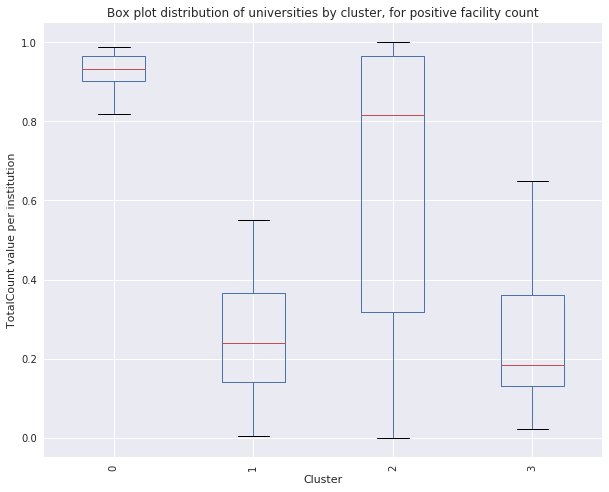

In [246]:
d = univ_merged[['UKPRN','CLUSTER','NSS_Q27','Outputs','TotalCount']]

ax = d.pivot(index='UKPRN',columns='CLUSTER',values='TotalCount').plot(kind='box', figsize=(10, 8), rot=90)

ax.set_xlabel('Cluster')
ax.set_ylabel('TotalCount value per institution')
ax.set_title('Box plot distribution of universities by cluster, for positive facility count') 

In [77]:
univ_merged.loc[univ_merged['CLUSTER'] == 0, univ_merged.columns[[1] + list(range(5, univ_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,CLUSTER,TotalCount
count,20.000000,20.000000,20.000000,19.000000,20.0,20.000000
mean,51.515207,123.600000,0.801000,68.147930,0.0,0.898225
std,0.017552,56.869565,0.055621,14.181491,0.0,0.112264
min,51.474144,24.000000,0.710000,41.000000,0.0,0.577932
25%,51.508177,81.250000,0.780000,61.412514,0.0,0.901235
50%,51.518622,133.000000,0.795000,68.776593,0.0,0.933256
75%,51.523906,146.750000,0.820000,77.997009,0.0,0.965085
max,51.551822,208.000000,0.910000,92.100000,0.0,0.989198


In [78]:
univ_merged.loc[univ_merged['CLUSTER'] == 1, univ_merged.columns[[1] + list(range(5, univ_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,CLUSTER,TotalCount
count,97.000000,97.000000,97.000000,97.000000,97.0,97.000000
mean,53.016117,111.195876,0.839175,63.893780,1.0,0.249531
std,1.791893,53.929669,0.040354,10.869312,0.0,0.133440
min,50.375186,1.000000,0.670000,44.738564,1.0,0.003858
25%,51.483596,66.000000,0.820000,54.800000,1.0,0.141204
50%,52.622394,111.000000,0.840000,62.510866,1.0,0.238426
75%,53.948437,162.000000,0.870000,73.897826,1.0,0.364969
max,57.469675,206.000000,0.940000,83.655952,1.0,0.550154


In [79]:
univ_merged.loc[univ_merged['CLUSTER'] == 2, univ_merged.columns[[1] + list(range(5, univ_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,CLUSTER,TotalCount
count,16.000000,12.000000,0.0,10.000000,16.0,16.000000
mean,51.900746,118.416667,NaN,70.218482,2.0,0.629533
std,0.773619,73.174087,NaN,14.414495,0.0,0.360436
min,51.485538,2.000000,NaN,44.400000,2.0,0.000000
25%,51.516034,88.000000,NaN,59.400000,2.0,0.318287
50%,51.525834,136.500000,NaN,72.555122,2.0,0.816744
75%,51.836715,163.500000,NaN,82.683545,2.0,0.966435
max,53.813246,205.000000,NaN,87.253478,2.0,1.000000


In [80]:
univ_merged.loc[univ_merged['CLUSTER'] == 3, univ_merged.columns[[1] + list(range(5, univ_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,CLUSTER,TotalCount
count,33.000000,32.000000,33.000000,24.000000,33.0,33.000000
mean,52.887561,83.562500,0.831212,32.333527,3.0,0.220375
std,1.574313,73.756328,0.042848,6.822049,0.0,0.139878
min,50.149168,7.000000,0.710000,10.600000,3.0,0.020833
25%,51.709495,27.750000,0.800000,29.228698,3.0,0.130401
50%,52.938545,53.000000,0.840000,33.311903,3.0,0.183642
75%,53.803662,125.250000,0.860000,35.854943,3.0,0.361111
max,57.118078,211.000000,0.910000,42.356932,3.0,0.650463


Based on a review of the above, give each cluster a descriptive label and map the results.

In [81]:
def label_clusters(row):
    if row['CLUSTER'] == 0:
        return 'High positive facilities, low NSS, high REF'
    if row['CLUSTER'] == 1:
        return 'Low positive facilities, high NSS, high REF'
    if row['CLUSTER'] == 2:
        return 'High positive facilities, no NSS, high REF'
    if row['CLUSTER'] == 3:
        return 'Low positive facilities, high NSS, low REF'
        
univ_merged['CLUSTER_NAME'] = univ_merged.apply (lambda row: label_clusters(row), axis=1)

In [82]:
x = univ_merged.groupby('CLUSTER_NAME').mean()
x['CountOfUnivs'] = univ_merged.groupby('CLUSTER_NAME').count()['UKPRN']
x[['NSS_Q27','Outputs','TotalCount','CountOfUnivs']]

,NSS_Q27,Outputs,TotalCount,CountOfUnivs
CLUSTER_NAME,,,,
"High positive facilities, low NSS, high REF",0.801000,68.147930,0.898225,20
"High positive facilities, no NSS, high REF",NaN,70.218482,0.629533,16
"Low positive facilities, high NSS, high REF",0.839175,63.893780,0.249531,97
"Low positive facilities, high NSS, low REF",0.831212,32.333527,0.220375,33


In [83]:
centre_latitude = 53.8083752
centre_longitude = -1.5542572

map_clusters = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, clustername in zip(univ_merged.LATITUDE, univ_merged.LONGITUDE, univ_merged.PROVIDER_NAME, univ_merged.CLUSTER, univ_merged.CLUSTER_NAME):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' (' + clustername + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    
print("Legend:")
print("Red, cluster 0, High positive facilities, low NSS, high REF")
print("Purple, cluster 1, Low positive facilities, high NSS, high REF")
print("Blue, cluster 2, High positive facilities, no NSS, high REF")
print("Yellow, cluster 3, Low positive facilities, high NSS, low REF")

map_clusters

Legend:
Red, cluster 0, High positive facilities, low NSS, high REF
Purple, cluster 1, Low positive facilities, high NSS, high REF
Blue, cluster 2, High positive facilities, no NSS, high REF
Yellow, cluster 3, Low positive facilities, high NSS, low REF


### Iteration 2: Focusing on a subset of clusters

The counts of universities in each cluster are not even, with the largest cluster (97) holding nearly three times the quantity of the second largest (33).  We see this again on the map, where the purple cluster contains a large and diverse number of geographic points.

Zooming in, we can see that London effectively has its own cluster (red), which is presumably a function of the density of all types of venues in the capital when compared to less dense urban areas and rural areas elsewhere in the country.

To investigate this further, we set aside the London cluster and the cluster which has no student satisfaction data, to focus on the remaining 130 institutions which have less polarised features.

We run the same k-means clustering and exploratory visualisations on this subset.

In [116]:
#Try dropping clusters 0 and 2 and segmenting the low facilities - rescale it.  Removes 36 universities

unisub_merged = univ_merged.loc[(univ_merged['CLUSTER'] == 1) | (univ_merged['CLUSTER'] == 3)]

min_max_scaler = preprocessing.MinMaxScaler()

unisubclust_df = unisub_merged.drop(columns=['PROVIDER_NAME','VIEW_NAME','SORT_NAME','LONGITUDE','LATITUDE','HESA_ID','CLUSTER','CLUSTER_NAME'])
unisubclust_scaled = unisubclust_df
unisubclust_scaled[['NSS_Q27','Outputs','TotalCount']] = min_max_scaler.fit_transform(unisubclust_df[['NSS_Q27','Outputs','TotalCount']])
unisubclust_scaled.fillna(0,inplace=True) # Uncertain about this step, non-participation in an exercise is not the same as a zero result
unisubclust_scaled.head()


,UKPRN,NSS_Q27,Outputs,TotalCount
0,10008640,0.481481,0.253976,0.152745
2,10007768,0.777778,0.890824,0.134845
3,10000571,0.518519,0.594692,0.099045
4,10007814,0.592593,0.992349,0.558473
5,10007158,0.629630,0.951809,0.486874


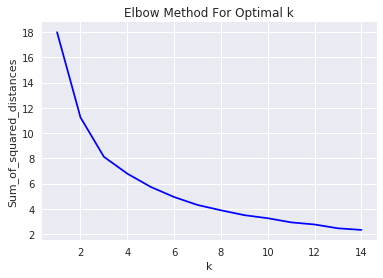

In [117]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(unisubclust_scaled.drop('UKPRN', 1))
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [118]:
# set number of clusters
kclusters = 4

unisub_grouped_clustering = unisubclust_scaled.drop('UKPRN', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(unisub_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
unisubclust_scaled.insert(0, 'Cluster Labels', kmeans.labels_)

unisubclust_scaled.drop(columns=['NSS_Q27','Outputs','TotalCount'],inplace=True)
unisub_merged = unisub_merged.join(unisubclust_scaled.set_index('UKPRN'), on='UKPRN')
unisub_merged.drop(columns=['CLUSTER_NAME','CLUSTER'],inplace=True) # This is all messy, ideally refactor code to tidy up this add/drop
unisub_merged.rename(columns={"Cluster Labels": "CLUSTER"},inplace=True)
unisub_merged.head()

,UKPRN,PROVIDER_NAME,VIEW_NAME,SORT_NAME,LONGITUDE,LATITUDE,HESA_ID,NSS_Q27,Outputs,TotalCount,CLUSTER
0,10008640,FALMOUTH UNIVERSITY,University College Falmouth,"Falmouth, University College",-5.070901,50.149168,17.0,0.80,29.154455,0.102623,3
2,10007768,UNIVERSITY OF LANCASTER,University of Lancaster,"Lancaster, University of",-2.786905,54.010480,123.0,0.88,75.680012,0.091049,1
3,10000571,BATH SPA UNIVERSITY,Bath Spa University,Bath Spa University,-2.437400,51.378739,48.0,0.81,54.045785,0.067901,3
4,10007814,CARDIFF UNIVERSITY,Cardiff University,Cardiff University,-3.179907,51.489093,179.0,0.83,83.097026,0.364969,0
5,10007158,UNIVERSITY OF SOUTHAMPTON,University of Southampton,"Southampton, University of",-1.395675,50.934180,160.0,0.84,80.135334,0.318673,0


/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NSS Q27 and Outputs:
Pearson's correlation coefficient: 0.214 (p-value: 0.018)
R-squared: 0.046 (p-value: 0.018)


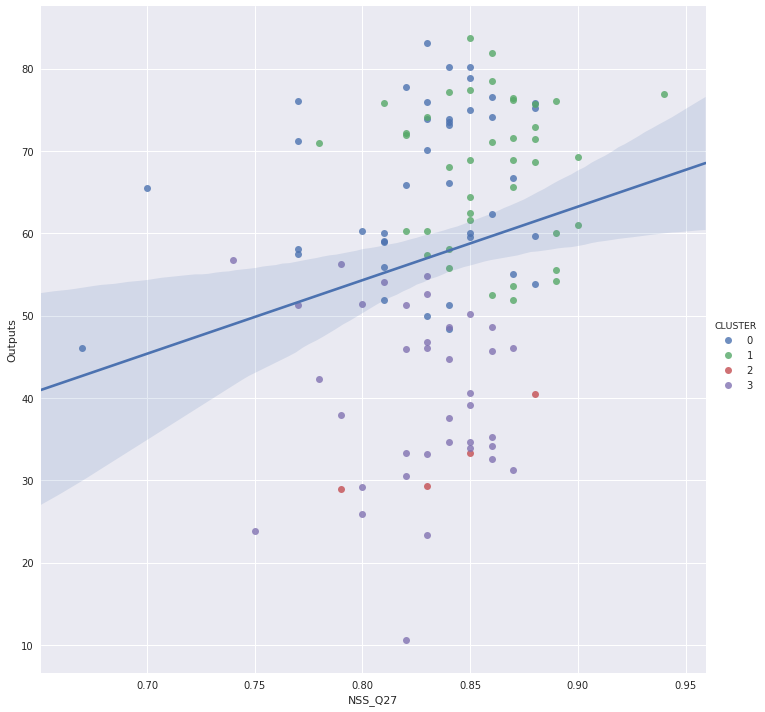

In [119]:
d = unisub_merged.loc[unisub_merged['NSS_Q27'] != 0].dropna() # not satisfied with dropping the null values here, would really prefer a refactor of this dataset to be clearer on what is in/out
graph = sns.lmplot(x='NSS_Q27',y='Outputs',data=d, hue='CLUSTER', fit_reg=False, height=10)
sns.regplot(x='NSS_Q27',y='Outputs',data=d, scatter=False, ax=graph.axes[0,0])

cor = stats.pearsonr(d['NSS_Q27'],d['Outputs']) 
slope, intercept, r_value, p_value, std_err = stats.linregress(d['NSS_Q27'],d['Outputs'])

print("NSS Q27 and Outputs:")
print("Pearson's correlation coefficient: {:.3f} (p-value: {:.3f})".format(cor[0], cor[1]))
print("R-squared: {:.3f} (p-value: {:.3f})".format(r_value**2, p_value))

NSS Q27 and positive facility count:
Pearson's correlation coefficient: -0.239 (p-value: 0.008)
R-squared: 0.057 (p-value: 0.008)


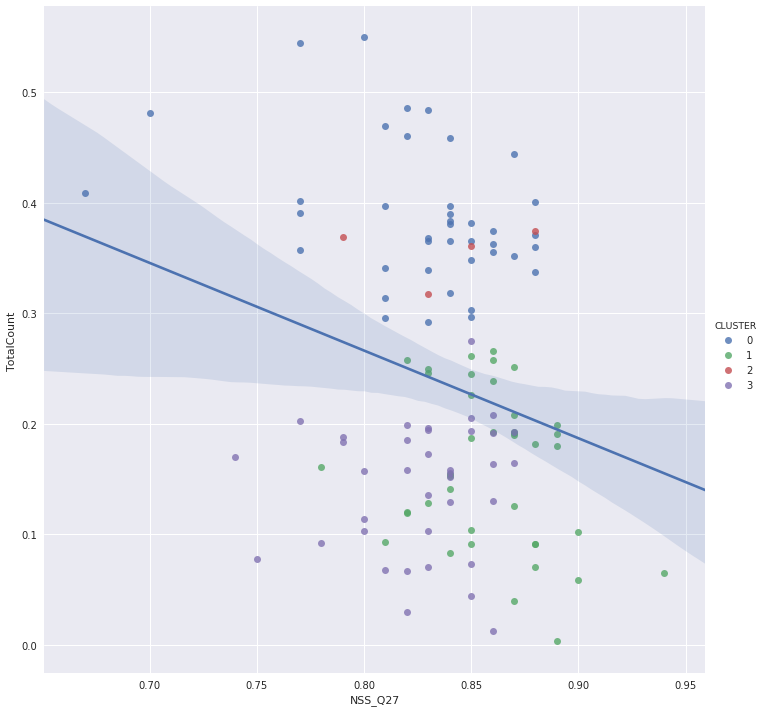

In [120]:
d = unisub_merged.loc[unisub_merged['NSS_Q27'] != 0].dropna()
graph = sns.lmplot(x='NSS_Q27',y='TotalCount',data=d, hue='CLUSTER', fit_reg=False, height=10)
sns.regplot(x='NSS_Q27',y='TotalCount',data=d, scatter=False, ax=graph.axes[0,0])

cor = stats.pearsonr(d['NSS_Q27'],d['TotalCount']) # not satisfied with dropping the null values here, would really prefer a refactor of this dataset to be clearer on what is in/out
slope, intercept, r_value, p_value, std_err = stats.linregress(d['NSS_Q27'],d['TotalCount'])

print("NSS Q27 and positive facility count:")
print("Pearson's correlation coefficient: {:.3f} (p-value: {:.3f})".format(cor[0], cor[1]))
print("R-squared: {:.3f} (p-value: {:.3f})".format(r_value**2, p_value))

Outputs and positive facility count:
Pearson's correlation coefficient: 0.272 (p-value: 0.003)
R-squared: 0.074 (p-value: 0.003)


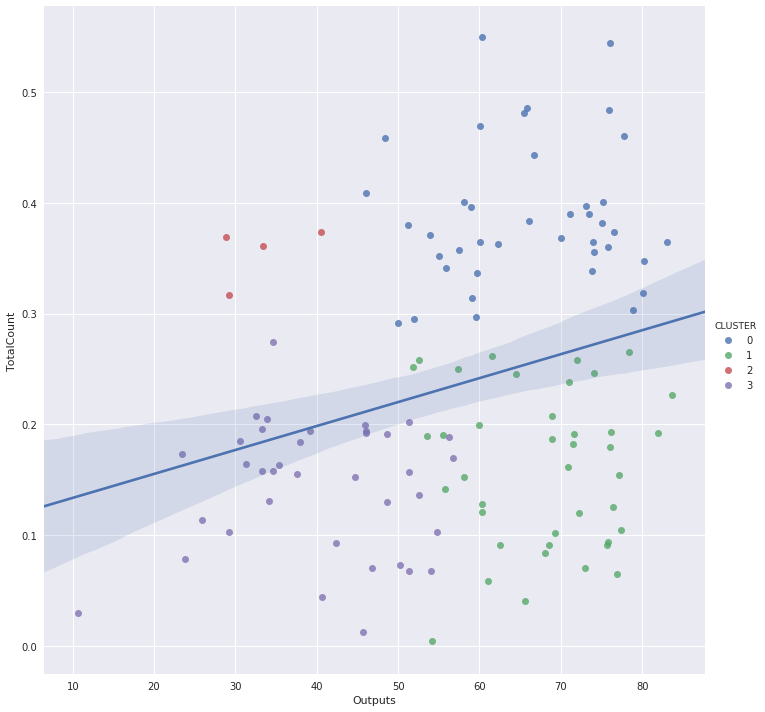

In [121]:
d = unisub_merged.loc[unisub_merged['Outputs'] != 0].dropna()  # not satisfied with dropping the null values here, would really prefer a refactor of this dataset to be clearer on what is in/out

graph = sns.lmplot(x='Outputs',y='TotalCount',data=d, hue='CLUSTER', fit_reg=False, height=10)
sns.regplot(x='Outputs',y='TotalCount',data=d, scatter=False, ax=graph.axes[0,0])

cor = stats.pearsonr(d['Outputs'],d['TotalCount'])
slope, intercept, r_value, p_value, std_err = stats.linregress(d['Outputs'],d['TotalCount'])

print("Outputs and positive facility count:")
print("Pearson's correlation coefficient: {:.3f} (p-value: {:.3f})".format(cor[0], cor[1]))
print("R-squared: {:.3f} (p-value: {:.3f})".format(r_value**2, p_value))


In [122]:
x = unisub_merged.groupby('CLUSTER').mean()
x['CountOfUnivs'] = unisub_merged.groupby('CLUSTER').count()['UKPRN']
x[['NSS_Q27','Outputs','TotalCount','CountOfUnivs']]

,NSS_Q27,Outputs,TotalCount,CountOfUnivs
CLUSTER,,,,
0,0.826500,65.908247,0.387249,40
1,0.858750,67.756269,0.160224,40
2,0.824545,32.998550,0.378157,11
3,0.829487,40.408823,0.138928,39


Using this subset of non-London universities which have NSS results, we see the 4 clusters which have appeared have more balanced numbers of universities within them, with three clusters holding aroud 40 universities and the final holding 11.

Interestingly, while the scatters incorporating the NSS results show high overlap between the clusters, the final scatter chart showing the relationship between REF outputs and counts of positive facilities now shows very clear separation of the four clusters from our subset of data.  Those with high REF outputs are equally present in areas with high positive facilities and areas with low positive facilities.  Those with low REF output scores have a tendency to be present in areas with low positive facilities, and most notably, there are few universities in areas with high positive facilities which have low REF output scores.  That is, if a university is in a high positive venue area, it is likely to have high REF output scores.

In [223]:
def label_sub_clusters(row):
    if row['CLUSTER'] == 0:
        return 'High positive facilities, low NSS, high REF'
    if row['CLUSTER'] == 1:
        return 'Low positive facilities, high NSS, high REF'
    if row['CLUSTER'] == 2:
        return 'High positive facilities, low NSS, low REF'
    if row['CLUSTER'] == 3:
        return 'Low positive facilities, low NSS, low REF'
        
unisub_merged['CLUSTER_NAME'] = unisub_merged.apply (lambda row: label_sub_clusters(row), axis=1)

In [224]:
unisub_merged.loc[unisub_merged['CLUSTER'] == 0, unisub_merged.columns[[1] + list(range(5, unisub_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,TotalCount,CLUSTER,CLUSTER_DBSCAN
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.000000
mean,53.182084,117.375000,0.826500,65.908247,0.387249,0.0,-0.725000
std,1.729512,53.160949,0.044753,10.240311,0.063828,0.0,0.452203
min,50.741781,31.000000,0.670000,46.100000,0.291667,0.0,-1.000000
25%,51.483586,68.250000,0.810000,58.722108,0.350887,0.0,-1.000000
50%,53.380311,111.000000,0.840000,65.978380,0.372685,0.0,-1.000000
75%,54.575950,164.750000,0.850000,75.058613,0.403164,0.0,0.000000
max,55.948003,204.000000,0.880000,83.097026,0.550154,0.0,0.000000


In [225]:
unisub_merged.loc[unisub_merged['CLUSTER'] == 1, unisub_merged.columns[[1] + list(range(5, unisub_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,TotalCount,CLUSTER,CLUSTER_DBSCAN
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.0
mean,53.148004,119.400000,0.858750,67.756269,0.160224,1.0,-1.0
std,1.915909,50.585698,0.029542,8.766746,0.070819,0.0,0.0
min,50.375186,1.000000,0.780000,51.882434,0.003858,1.0,-1.0
25%,51.582268,77.500000,0.840000,60.291814,0.099730,1.0,-1.0
50%,52.627113,120.500000,0.860000,69.111725,0.170525,1.0,-1.0
75%,54.150882,164.750000,0.880000,75.709065,0.212191,1.0,-1.0
max,57.469675,196.000000,0.940000,83.655952,0.265432,1.0,-1.0


In [226]:
unisub_merged.loc[unisub_merged['CLUSTER'] == 2, unisub_merged.columns[[1] + list(range(5, unisub_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,TotalCount,CLUSTER,CLUSTER_DBSCAN
count,11.000000,10.000000,11.000000,4.000000,11.000000,11.0,11.0
mean,52.452468,127.400000,0.824545,32.998550,0.378157,2.0,-1.0
std,1.242991,82.943354,0.055563,5.381588,0.113212,0.0,0.0
min,50.907738,30.000000,0.710000,28.900280,0.162809,2.0,-1.0
25%,51.493561,45.250000,0.795000,29.165154,0.362269,2.0,-1.0
50%,52.052585,137.000000,0.850000,31.308373,0.366512,2.0,-1.0
75%,53.601668,206.750000,0.865000,35.141768,0.388889,2.0,-1.0
max,54.592000,211.000000,0.880000,40.477173,0.650463,2.0,-1.0


In [227]:
unisub_merged.loc[unisub_merged['CLUSTER'] == 3, unisub_merged.columns[[1] + list(range(5, unisub_merged.shape[1]))]].describe()

,LATITUDE,HESA_ID,NSS_Q27,Outputs,TotalCount,CLUSTER,CLUSTER_DBSCAN
count,39.000000,39.000000,39.000000,37.000000,39.000000,39.0,39.0
mean,52.760824,69.615385,0.829487,40.408823,0.138928,3.0,-1.0
std,1.662286,57.600537,0.034940,10.748452,0.061591,0.0,0.0
min,50.149168,7.000000,0.740000,10.600000,0.012346,3.0,-1.0
25%,51.608618,24.500000,0.815000,33.260508,0.087963,3.0,-1.0
50%,52.272007,53.000000,0.830000,40.612419,0.157407,3.0,-1.0
75%,53.566716,92.500000,0.850000,48.647594,0.189815,3.0,-1.0
max,57.118078,206.000000,0.910000,56.704550,0.274691,3.0,-1.0


In [228]:
x = unisub_merged.groupby('CLUSTER_NAME').mean()
x['CountOfUnivs'] = unisub_merged.groupby('CLUSTER_NAME').count()['UKPRN']
x[['NSS_Q27','Outputs','TotalCount','CountOfUnivs']]

,NSS_Q27,Outputs,TotalCount,CountOfUnivs
CLUSTER_NAME,,,,
"High positive facilities, low NSS, high REF",0.826500,65.908247,0.387249,40
"High positive facilities, low NSS, low REF",0.824545,32.998550,0.378157,11
"Low positive facilities, high NSS, high REF",0.858750,67.756269,0.160224,40
"Low positive facilities, low NSS, low REF",0.829487,40.408823,0.138928,39


In [124]:
centre_latitude = 53.8083752
centre_longitude = -1.5542572

map_clusters = folium.Map(location=[centre_latitude, centre_longitude],  zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, clustername in zip(unisub_merged.LATITUDE, unisub_merged.LONGITUDE, unisub_merged.PROVIDER_NAME, unisub_merged.CLUSTER, unisub_merged.CLUSTER_NAME):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' (' + clustername + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

   
print("Legend:")
print("Red, cluster 0, High positive facilities, low NSS, high REF")
print("Purple, cluster 1, Low positive facilities, high NSS, high REF")
print("Blue, cluster 2, High positive facilities, low NSS, low REF")
print("Yellow, cluster 3, Low positive facilities, low NSS, low REF")

map_clusters    


Legend:
Red, cluster 0, High positive facilities, low NSS, high REF
Purple, cluster 1, Low positive facilities, high NSS, high REF
Blue, cluster 2, High positive facilities, low NSS, low REF
Yellow, cluster 3, Low positive facilities, low NSS, low REF


Again, running a test using DBScan required high epsilon values (0.5 with a normalised range of 0-1.0) and low minimum sample values (10 from 130) to begin to separate any cluster from the noise, which likely indicates that the dataset does not cluster well (either in general or using this density method).  

In [169]:
sklearn.utils.check_random_state(1000)
Clus_dataSet = unisub_merged[['NSS_Q27','Outputs','TotalCount']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unisub_merged['CLUSTER_DBSCAN'] = labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Count of universities in each cluster:')
unisub_merged[['CLUSTER_DBSCAN','UKPRN']].groupby('CLUSTER_DBSCAN').count()

Estimated number of clusters: 1
Estimated number of noise points: 119
Count of universities in each cluster:


,UKPRN
CLUSTER_DBSCAN,
-1,119
0,11


### Iteration 3: all features

The below blocks of code simply re-run the process from iteration 1, but building a more complete featureset.  This code is not documented further - refer to the notes in iteration 1 for context.

In [183]:
x3_df = uni_df

nss_pivot_df = nss_df.pivot_table(values='Actual value', index=['UKPRN'], columns=['Question Number']).reset_index()
nss_pivot_df['UKPRN'] = nss_pivot_df['UKPRN'].astype(str)
nss_pivot_df.set_index('UKPRN',inplace=True)

x3_merge_df = x3_df.merge(nss_pivot_df,how='left',on='UKPRN')
x3_merge_df.head()

x3_df = x3_merge_df.merge(ref_34star_pivot_df,how='left',on='UKPRN')
x3_df.set_index("UKPRN")

uni_group2 = uni_group.reset_index()

x3_all_df = x3_df.merge(uni_group2,how='left',on='UKPRN')
x3_all_df.fillna(0,inplace=True)
null_columns = x3_all_df.columns[x3_all_df.isnull().any()]
x3_all_df.drop(columns=['Overall'],inplace=True)
#list(x3_all_df)

In [207]:

min_max_scaler = preprocessing.MinMaxScaler()

x3_allclust_df = x3_all_df.drop(columns=['PROVIDER_NAME','VIEW_NAME','SORT_NAME','LONGITUDE','LATITUDE','HESA_ID'])
x3_allclust_scaled = x3_allclust_df
x3_allclust_scaled = min_max_scaler.fit_transform(x3_allclust_scaled)
#x3_allclust_scaled.fillna(0,inplace=True) # Uncertain about this step, non-participation in an exercise is not the same as a zero result
#x3_allclust_scaled.head()
x3_allclust_normalized = pd.DataFrame(x3_allclust_scaled, columns=x3_allclust_df.columns)

x3_allclust_normalized.drop(columns=['UKPRN'],inplace=True)
x3_allclust_normalized['UKPRN'] = x3_allclust_df['UKPRN'] 
x3_allclust_normalized.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,NHS1,NHS2,NHS3,NHS4,NHS5,NHS6,Q01,Q02,Q03,Q04,...,Water Park,Waterfall,Waterfront,Weight Loss Center,Well,Whisky Bar,Windmill,Yoga Studio,Zoo,UKPRN
0,0.00,0.00,0.00,0.00,0.00,0.00,0.927083,0.885417,0.814433,0.877778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,10008640
1,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,10007774
2,0.00,0.00,0.00,0.00,0.00,0.00,0.947917,0.843750,0.917526,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,10007768
3,0.00,0.00,0.00,0.00,0.00,0.00,0.927083,0.875000,0.814433,0.866667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,10000571
4,0.74,0.91,0.86,0.92,0.91,0.85,0.927083,0.843750,0.886598,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,10007814


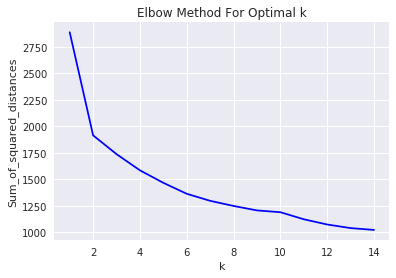

In [208]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x3_allclust_normalized.drop('UKPRN', 1))
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [209]:
# set number of clusters
kclusters = 5

x3_grouped_clustering = x3_allclust_normalized.drop('UKPRN', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(x3_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
x3_allclust_normalized.insert(0, 'Cluster Labels', kmeans.labels_)

#x3_allclust_normalized.drop(columns=['NSS_Q27','Outputs'],inplace=True)
x3_allclust_normalized
x3_all_merged = x3_all_df.join(x3_allclust_normalized[['UKPRN','Cluster Labels']].set_index('UKPRN'), on='UKPRN')
#uniall_merged.drop(columns=['Overall'],inplace=True)
x3_all_merged.rename(columns={"Cluster Labels": "CLUSTER_ALLFEAT"},inplace=True)

In [210]:
x = x3_all_merged.groupby('CLUSTER_ALLFEAT').mean()
x['CountOfUnivs'] = x3_all_merged.groupby('CLUSTER_ALLFEAT').count()['UKPRN']
x

,LONGITUDE,LATITUDE,HESA_ID,NHS1,NHS2,NHS3,NHS4,NHS5,NHS6,Q01,...,Water Park,Waterfall,Waterfront,Weight Loss Center,Well,Whisky Bar,Windmill,Yoga Studio,Zoo,CountOfUnivs
CLUSTER_ALLFEAT,,,,,,,,,,,,,,,,,,,,,
0,-1.711925,52.608208,92.366197,0.793521,0.920282,0.867746,0.918732,0.889859,0.865634,0.889577,...,0.014085,0.042254,0.042254,0.408451,0.000000,0.042254,0.028169,0.915493,0.281690,71
1,-0.118609,51.521810,126.900000,0.179000,0.222500,0.213500,0.226000,0.214000,0.222500,0.684000,...,0.000000,1.000000,0.550000,0.000000,0.000000,0.000000,0.000000,0.850000,2.400000,20
2,-1.709999,52.394083,65.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.285714,7
3,-2.196302,53.370963,116.262295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.892623,...,0.016393,0.065574,0.098361,0.278689,0.032787,0.016393,0.032787,0.754098,0.245902,61
4,-0.177374,51.508951,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.257143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.285714,2.714286,7


In [241]:
x3_retotal = x3_all_merged.drop(columns=['NHS1','NHS2','NHS3','NHS4','NHS5','NHS6','Q01','Q02','Q03','Q04','Q05','Q06','Q07','Q08','Q09','Q10','Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19','Q20','Q21','Q22','Q23','Q24','Q25','Q26','Q27','Outputs','Environment','Impact','LONGITUDE','LATITUDE','HESA_ID','UKPRN'])
x3_all_merged['TotalCount'] = x3_retotal.sum(axis=1)

In [244]:
x3_all_merged[['CLUSTER_ALLFEAT','Q27','Outputs','TotalCount']].groupby('CLUSTER_ALLFEAT').describe()
#list(x3_all_merged)

Q27                                                      \
                count      mean       std   min   25%   50%     75%   max   
CLUSTER_ALLFEAT                                                             
0                71.0  0.837324  0.033507  0.75  0.82  0.84  0.8600  0.90   
1                20.0  0.637000  0.330742  0.00  0.71  0.79  0.8125  0.91   
2                 7.0  0.000000  0.000000  0.00  0.00  0.00  0.0000  0.00   
3                61.0  0.835246  0.048874  0.67  0.81  0.84  0.8700  0.94   
4                 7.0  0.244286  0.417686  0.00  0.00  0.00  0.4100  0.89   

                Outputs             ...                       TotalCount  \
                  count       mean  ...        75%        max      count   
CLUSTER_ALLFEAT                     ...                                    
0                  71.0  56.893855  ...  72.445894  83.097026       71.0   
1                  20.0  55.333310  ...  75.383633  92.100000       20.0   
2                   7.0  42.548582  ...  79.565187  83.309699        7.0   
3                  61.0  49.861995  ...  68.611423  83.655952       61.0   
4                   7.0  69.306437  ...  84.145791  87.253478        7.0   

                                                                          \
                        mean         std     min     25%     50%     75%   
CLUSTER_ALLFEAT                                                            
0                 350.535211  155.818835    75.0   230.0   342.0   488.0   
1                1240.900000   69.313096  1050.0  1223.5  1271.0  1285.0   
2                 347.857143  171.416091    25.0   300.5   421.0   452.0   
3                 339.327869  211.961767    31.0   159.0   274.0   511.0   
4                1193.285714   92.160574  1034.0  1155.5  1205.0  1240.0   

                         
                    max  
CLUSTER_ALLFEAT          
0                 848.0  
1                1306.0  
2                 484.0  
3                 869.0  
4                1323.0  

[5 rows x 24 columns]

In [211]:
centre_latitude = 53.8083752
centre_longitude = -1.5542572

map_clusters = folium.Map(location=[centre_latitude, centre_longitude],  zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, clustername in zip(x3_all_merged.LATITUDE, x3_all_merged.LONGITUDE, x3_all_merged.PROVIDER_NAME, x3_all_merged.CLUSTER_ALLFEAT, str(x3_all_merged.CLUSTER_ALLFEAT)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' (' + clustername + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

   
print("Legend:")
#print("Red, cluster 0, High positive facilities, low NSS, high REF")
#print("Purple, cluster 1, Low positive facilities, high NSS, high REF")
#print("Blue, cluster 2, High positive facilities, low NSS, low REF")
#print("Yellow, cluster 3, Low positive facilities, low NSS, low REF")

map_clusters    


Legend:


In [219]:
compare_df = univ_merged[['UKPRN','CLUSTER_NAME']].join(x3_all_merged[['UKPRN','CLUSTER_ALLFEAT']].set_index('UKPRN'), on='UKPRN')

compare_df.head()

,UKPRN,CLUSTER_NAME,CLUSTER_ALLFEAT
0,10008640,"Low positive facilities, high NSS, low REF",3
1,10007774,"High positive facilities, no NSS, high REF",2
2,10007768,"Low positive facilities, high NSS, high REF",3
3,10000571,"Low positive facilities, high NSS, high REF",3
4,10007814,"Low positive facilities, high NSS, high REF",0


In [221]:
compare_pivot = compare_df.pivot_table(values=['UKPRN'], index=['CLUSTER_NAME'], columns=['CLUSTER_ALLFEAT'],aggfunc=pd.Series.nunique)
compare_pivot

UKPRN                      
CLUSTER_ALLFEAT                                 0     1    2     3    4
CLUSTER_NAME                                                           
High positive facilities, low NSS, high REF   1.0  16.0  NaN   1.0  2.0
High positive facilities, no NSS, high REF    NaN   4.0  7.0   NaN  5.0
Low positive facilities, high NSS, high REF  55.0   NaN  NaN  42.0  NaN
Low positive facilities, high NSS, low REF   15.0   NaN  NaN  18.0  NaN